## Introduction

In [2]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd
from numpy.typing import NDArray
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import accuracy_score, f1_score

np.random.seed(1234)

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Metrics 

We have a classification problem with a strong imbalance on the target class. This time we will asume equally important the missclassification errors for both classes. For this reason we are going to use the next metrics to evaluate our model:
* Accuracy. (Just for checking, accuracy is not the best metric with imbalanced data)
* Precision for all classes. 
* Recall for all classes. 
* F1-score micro average.
* F1-score macro average. 


In [12]:
def get_metrics(y_pred: NDArray, y_test: pd.core.series.Series) -> list:
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1_score_w = f1_score(y_test, y_pred, average='weighted')
    f1_score_m = f1_score(y_test, y_pred, average='macro')
    return [accuracy, recall, precision, f1_score_w, f1_score_m]

results = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1-score weighted', 'F1-score macro.'])

# MODEL CLASSIFICATION

First of all, read the preprocessed data. It is important to be this data and not the original, because they are saved in a .csv file as it was done in the preprocessing.

In [5]:
# read clean data
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')['Severity']
X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv')['Severity']

### Resampling protocl

It is very important to make a good resampling protocol.

For further information, check out the report. As a resume, we have two datasets, one for training and another one for validation.

# MODELS OF DECISION TREE FAMILY

## Model 1: Decision Tree Classifier

First model we are going to take into account is a Decision Tree Classifier due to its simplicity and interpretability and the fact that it is a good starting point for more complex models. As explained detailedly in the report, we are going to use a cross validation to find the best hyperparameters for this model based on validation metric: f1-score micro.

In [4]:
criterion = ['gini', 'entropy']

max_dephts = [None, 5, 10, 15]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto', 'sqrt', 'log2', None]

dec_tree_model = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=dec_tree_model,
                   param_grid={
                          'criterion': criterion,
                          'max_depth': max_dephts,
                          'min_samples_split': min_samples_split,
                          'min_samples_leaf': min_samples_leaf,
                          'max_features': max_features
                   },
                   scoring='f1_weighted',
                   cv=5,
                   n_jobs=-1,
)
grid_search.fit(X_train, y_train)
best_params_dec_tree = grid_search.best_params_

/home/pol/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/pol/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.wa

Fit the decision tree classifier with best hyperparameters and evaluate it with the test set.

In [ ]:
best_dec_tree_model = DecisionTreeClassifier(**best_params_dec_tree)
best_dec_tree_model.fit(X_train, y_train)

In [8]:
y_pred_dec_tree = best_dec_tree_model.predict(X_test)

results.loc['Decision Tree'] = get_metrics(y_pred_dec_tree, y_test)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted,F1-score macro.
DecisionTreeClassifier,0.822593,0.822593,0.800702,0.807829,0.474993


Now, let's plot the ROC curve and calculate the AUC for the Decision Tree Classifier for every category of classification. Plotting the ROC curve is a good way to visualize the performance of a classifier.

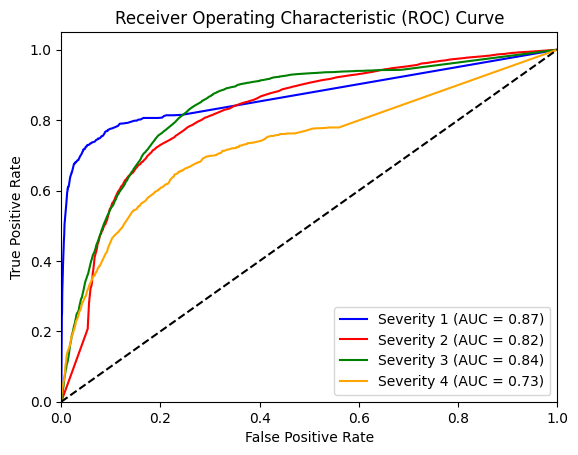

In [9]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Get the predicted probabilities for each class
y_pred_proba = best_dec_tree_model.predict_proba(X_test)

# Compute ROC curve and ROC AUC for each class
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test == i+1, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange']
for i in range(4):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='Severity {} (AUC = {:.2f})'.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Model 2: Random Forest Classifier

Second model we are going to take into account is a Random Forest Classifier. This model is an ensemble of decision trees, which makes it more robust to overfitting and more accurate than a single decision tree. As explained detailedly in the report, we are going to use a cross validation to find the best hyperparameters for this model based on validation metric: f1-score weighted.

In [23]:
rf_model = RandomForestClassifier()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

param_grid = {
    'n_estimators': [100, None],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3]
}

grid_search = GridSearchCV(rf_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params_rf = grid_search.best_params_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, None]},
             scoring='f1_weighted')

In [25]:
best_rf_model = RandomForestClassifier(**best_params_rf)    
best_rf_model.fit(X_train, y_train)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [26]:
y_pred_rf = best_rf_model.predict(X_test)

results.loc["Random Forest"] = get_metrics(y_pred_rf, y_test)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted,F1-score macro.
DecisionTreeClassifier,0.822593,0.822593,0.800702,0.807829,0.474993
RandomForestClassifier,0.836859,0.836859,0.817847,0.806129,0.430045


## Model 3: Extra Trees Classifier

Extra Trees creates multiple highly randomized trees and averages their predictions to reduce variance. It uses random splits and the full dataset for training each tree, making it faster and robust to overfitting compared to Random Forest.

In [27]:
extra_trees_model = ExtraTreesClassifier()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234, )

param_grid = {
    'n_estimators': [100, None],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3]
}

grid_search = GridSearchCV(extra_trees_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)

grid_search.fit(X_train, y_train)
best_params_extra_trees = grid_search.best_params_

In [ ]:
best_extra_trees_model = ExtraTreesClassifier(**best_params_extra_trees)
best_extra_trees_model.fit(X_train, y_train)

In [ ]:
y_pred_extra_trees = best_extra_trees_model.predict(X_test)

results.loc["Extra Trees"] = get_metrics(y_pred_extra_trees, y_test)
results.sort_values(by='F1-score weighted', ascending=False)

## Model 4: Gradient Boosting

Gradient Boosting corrects errors made by previous models by building new models that predict the residuals. It combines these models to make accurate predictions and uses hyperparameters like learning rate and number of trees to control the model's complexity.

In [ ]:
gb_model = GradientBoostingClassifier()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(gb_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)

grid_search.fit(X_train, y_train)
best_params_gb = grid_search.best_params_

In [ ]:
best_extra_gb = GradientBoostingClassifier(**best_params_gb)
best_extra_gb.fit(X_train, y_train)

In [ ]:
y_pred_gb = best_extra_gb.predict(X_test)

results.loc["Gradient Boosting"] = get_metrics(y_pred_gb, y_test)
results.sort_values(by='F1-score weighted', ascending=False)

## Model 5: LOGISTIC REGRESSION

Search the optimal value of the hyperparameter C and the penalty method for the Logistic Regression model using cross validation. We are going to use the same metric as in the Random Forest Classifier: f1-score weighted.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
logreg_model = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['saga']
}

grid_search = GridSearchCV(logreg_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [ ]:
bes_logreg_model = LogisticRegression(**best_params)
bes_logreg_model.fit(X_train, y_train)

In [ ]:
y_pred_logreg = bes_logreg_model.predict(X_test)

results.loc['Logistic Regression'] = get_metrics(y_pred_logreg, y_test)
results.sort_values(by='F1-score weighted', ascending=False)

## Model 6: QDA

This model is used to predict the class from an input feature space. The model is based on prior probabilities on the input data. It assumes they are Gaussian distributed, so it was important to normalize the data in the preprocessing.

In [6]:
#We will do a 5-fold cross-validation to find the best hyperparameters for the QDA model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
qda_model = QuadraticDiscriminantAnalysis()

param_grid = {'reg_param': [0, 0.001, 0.01, 0.1, 0.2, 0.5, 1]}

grid_search = GridSearchCV(qda_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params_qda = grid_search.best_params_
best_score_qda = grid_search.best_score_

In [7]:
best_qda_model = QuadraticDiscriminantAnalysis(**best_params_qda)
best_qda_model.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(reg_param=0.1)

In [15]:
y_pred_qda = best_qda_model.predict(X_test)

results.loc['QDA'] = get_metrics(y_pred_qda, y_test)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted,F1-score macro.
QDA,0.771118,0.771118,0.777314,0.772005,0.402249


## Model 7: LDA

This model is very similar to the previous one, here we will suppose that every class in Severity has the same covariance matrix.

In [16]:
#We will do a 5-fold cross-validation to find the best hyperparameters for the LDA model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234, )

param_grid = {'solver': ['lsqr', 'eigen'], 'shrinkage': [0, 0.1, 0.2, 0.5]}
lda_model = LinearDiscriminantAnalysis()
grid_search = GridSearchCV(lda_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params_lda = grid_search.best_params_
best_score_lda = grid_search.best_score_

In [17]:
best_lda_model = LinearDiscriminantAnalysis(**best_params_lda)
best_lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis(shrinkage=0, solver='lsqr')

In [19]:
y_pred_lda = best_lda_model.predict(X_test)

results.loc['LDA'] = get_metrics(y_pred_lda, y_test)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted,F1-score macro.
QDA,0.771118,0.771118,0.777314,0.772005,0.402249
LDA,0.800862,0.800862,0.756098,0.761584,0.299140


The results for QDA and LDA are not the same, it may be due to te fact that every class does not have the same variance-covariance matrix, that is the assumption made for doing LDA.

## Model 8: GAUSSIAN NAIVE BAYE

Gaussian Naive Bayes (GNB) is a simple probabilistic classifier based on Bayes' theorem with the assumption of independence between features. In the preprocessing we saw that there is not a lot of correlation between variables, so we can apply this method.

In [20]:
#We will do a 5-fold cross-validation to find the best hyperparameters for the GNB model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234, )

#For the priors we will use the default values of None and the proportion of every class in training the dataset
class_counts = y_train.value_counts()
class_counts_sorted = class_counts.sort_index()
class_proportions = class_counts_sorted / len(y_train)
param_grid = {'priors': [None, class_proportions.values]}
gnb_model = GaussianNB()
grid_search = GridSearchCV(gnb_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params_gnb = grid_search.best_params_
best_score_gnb = grid_search.best_score_

In [21]:
best_gnb_model = GaussianNB(**best_params_gnb)
best_gnb_model.fit(X_train, y_train)

GaussianNB()

In [22]:
y_pred_gnb = best_gnb_model.predict(X_test)

results.loc['GNB'] = get_metrics(y_pred_gnb, y_test)
results.sort_values(by='F1-score weighted', ascending=False)

,Accuracy,Recall,Precision,F1-score weighted,F1-score macro.
QDA,0.771118,0.771118,0.777314,0.772005,0.402249
LDA,0.800862,0.800862,0.756098,0.761584,0.299140
GNB,0.332692,0.332692,0.793860,0.338283,0.224078


As we see this models does not fit well the data. This could be due to we supposed variables were uncorrelated, but in fact they are. Thus there exists dependece between variables, and this method cannot be applied.

## Model 9: $k$-NN

This methods predicts the actual sample by using similar properties from the k nearest neighbours. Each new sample will go to the class with the most similar values from the train set. 

In [24]:
#We will do a 5-fold cross-validation to find the best hyperparameters for the LDA model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234, )

#For the priors we will use the default values of None and the proportion of every class in training the dataset
param_grid = {'n_neighbors': [1, 3, 10, 20], 'metric': ['euclidean', 'minkowski', 'manhattan']}
knn_model = KNeighborsClassifier()
grid_search = GridSearchCV(knn_model, param_grid = param_grid, cv = cv, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params_knn = grid_search.best_params_

In [ ]:
best_knn_model = KNeighborsClassifier(**best_params_knn)
best_knn_model.fit(X_train, y_train)

In [ ]:
y_pred_knn = best_knn_model.predict(X_test)

results.loc['KNN'] = get_metrics(y_pred_knn, y_test)
results.sort_values(by='F1-score weighted', ascending=False)